# Случайные процессы. Прикладной поток.
## Практическое задание 8

Прогнозирование временных рядов.

**Правила:**

* Выполненную работу нужно отправить на почту `probability.diht@yandex.ru`, указав тему письма `"[СП17] Фамилия Имя - Задание 10"`. Квадратные скобки обязательны, внутри них пробела быть не должно. Вместо `Фамилия Имя` нужно подставить свои фамилию и имя.
* Прислать нужно ноутбук и его pdf-версию. Названия файлов должны быть такими: `10.N.ipynb` и `10.N.pdf`, где `N` - ваш номер из таблицы с оценками.
* Никакой код из данного задания при проверке запускаться не будет.

В файле `ftse100.csv` ([отсюда](ftse100.csv)) содержится информация о значении индекса [FTSE](https://ru.wikipedia.org/wiki/FTSE_100) за каждый рабочий день на момент закрытия с января 1980 года по март 2004 года.

В файле `internet-traffic.csv` ([отсюда](internet-traffic.csv)) содержится информация о величине интернет-трафика (в битах) в академической сети Великобритании с 19 ноября 2004 года до 27 января 2005 года за каждый час.

In [779]:
import warnings
import itertools
import scipy.stats as sps
import pandas as pd
import numpy as np
import datetime
import statsmodels.api as sm
from tqdm import tqdm_notebook
import tqdm

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

plt.style.use('seaborn-talk')

**Задание:**

<span>1.</span> Нарисуйте график временного ряда. По графику на глаз определите, какие типы разладок могут происходить. Это могут быть, например, разладки ”увеличение средного”, ”уменьшение дисперсии”. По данным не нужно определять величину изменения харатеристики распределения при разладке. Нужно только решить, какие по величине отклонения вы считаете значимыми.

Для начала считаем данные

## Анализ интернет FTSE

In [780]:
df_FTSE = pd.read_csv('ftse100.csv', index_col=0)
df_FTSE.set_index('date', inplace=True)
df_FTSE.head()

,ftse100
date,
1984-04-02,-0.011461
1984-04-03,0.000000
1984-04-04,0.006208
1984-04-05,-0.005353
1984-04-06,0.000365


Теперь отобразим истинные значение FTSE, поскольку судя из вики страницы данные представлены с дельта сжатием

In [781]:
df_FTSE['cumsum'] = np.cumsum(df_FTSE['ftse100'])

Изобразим временные ряды истинного значения и получается что продифференциированного

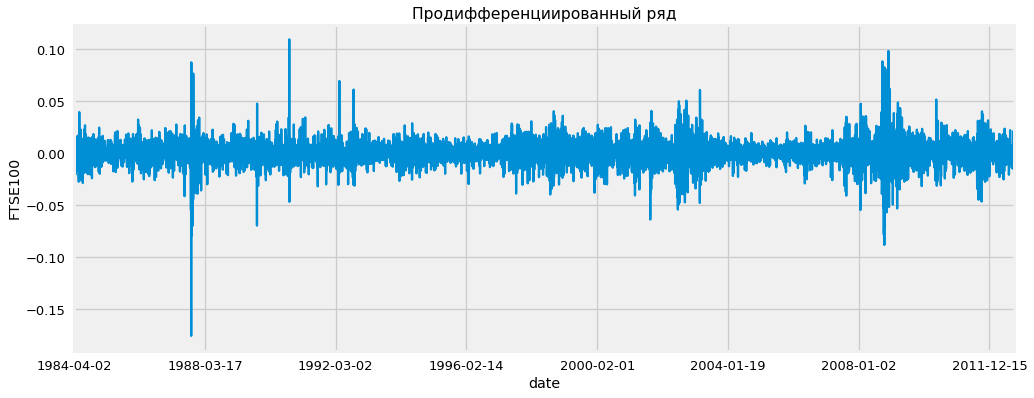

In [782]:
df_FTSE["ftse100"].plot(figsize=(15,6))
plt.ylabel("FTSE100")
plt.grid(True)
plt.title("Продифференциированный ряд")
plt.show()

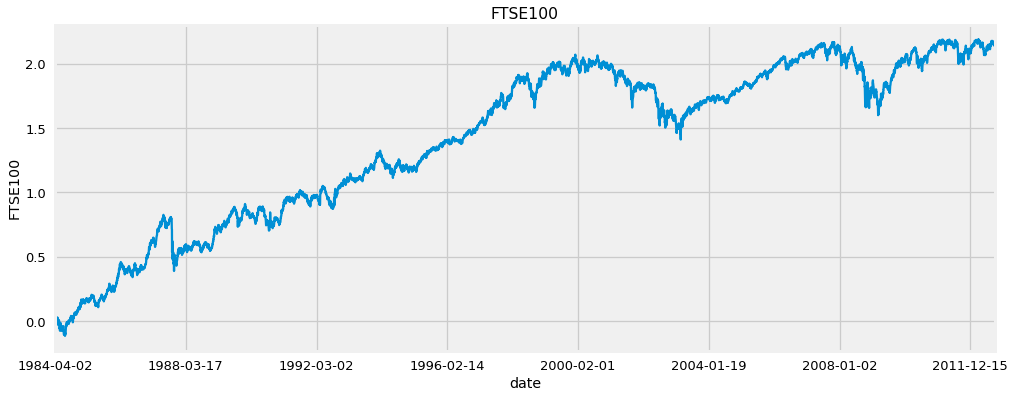

In [783]:
df_FTSE["cumsum"].plot(figsize=(15,6))
plt.ylabel("FTSE100")
plt.grid(True)
plt.title("FTSE100")
plt.show()

Отметим границы с которых начинаются какие-то странности для продифференцированнго ряда

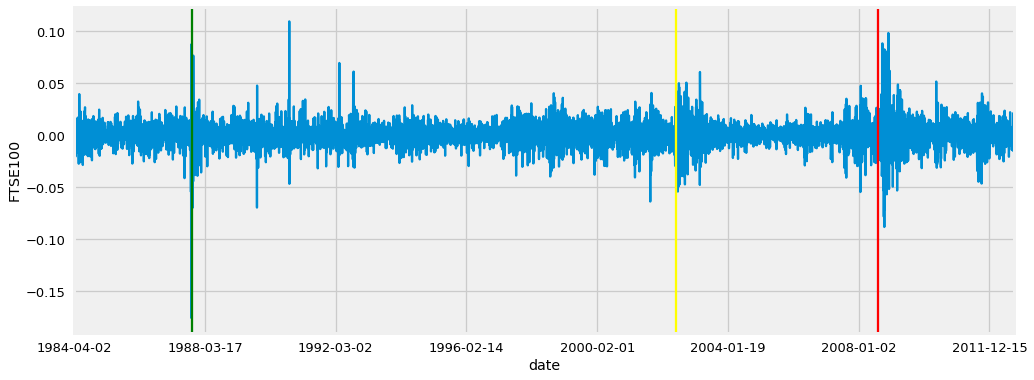

In [784]:
df_FTSE["ftse100"].plot(figsize=(15,6))
plt.axvline(900, -1, 1, color='green')
plt.axvline(4600, -1, 1, color='yellow')
plt.axvline(6150, -1, 1, color='red')
plt.ylabel("FTSE100")
plt.grid(True)
plt.show()

Отметим эти же значения на исходных данных

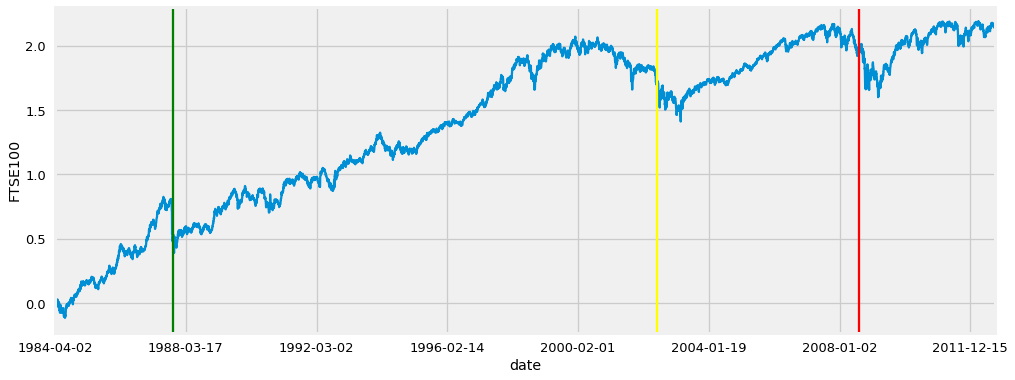

In [785]:
df_FTSE["cumsum"].plot(figsize=(15,6))
plt.axvline(901, -1, 1, color='green')
plt.axvline(4601, -1, 1, color='yellow')
plt.axvline(6151, -1, 1, color='red')
plt.ylabel("FTSE100")
plt.grid(True)
plt.show()

Как мы видим предложенные значения в точности совпадают с разладками: 
1. разрыв (зелёный)
2. излом (жёлтый и красный)

<span>2.</span> По небольшому начальному отрезку времени, в течении которого точно нет разладки, оцените распределение P$_{\infty}$. Над данными можно совершать любые преобразования, однако нужно следить за тем, чтобы в каждый момент времени не использовались данные из будущего.

Найдем эмперическое распределение и посмотрим на его график

In [786]:
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.nonparametric.kde import KDEUnivariate

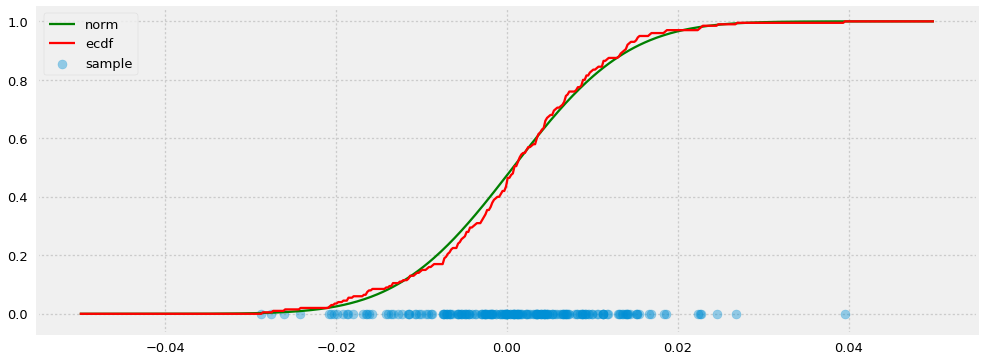

In [847]:
ftse_ecdf = ECDF(df_FTSE["ftse100"][:200])

grid = np.linspace(-0.05, 0.05, 500)

plt.figure(figsize=(15, 6))
plt.scatter(df_FTSE["ftse100"][:200], 
            np.zeros(200), alpha=0.4, label='sample')
plt.plot(grid, 
         sps.norm(np.mean(df_FTSE["ftse100"][:200]), 
                  np.std(df_FTSE["ftse100"][:200])).cdf(grid), 
         color='green', label='norm')
plt.plot(grid, ftse_ecdf(grid), color='red', label='ecdf')
plt.legend()
plt.grid(ls=':')
plt.show()

Получилось распределение очень похожее на нормальное

In [788]:
print("mean=", np.mean(df_FTSE["ftse100"][:850]), "std=", np.std(df_FTSE["ftse100"][:850]))

mean= 0.000906119054226 std= 0.00951640594497


<span>3.</span> По временному ряду запустите статистики CUMSUM и Ширяева-Робертса для детектирования всех предполагаемых типов разладок (т.е. одновременно несколько статистик для разных распределений).

Реализуем предложенные статистики

In [789]:
def CUMSUM(X, f_inf, f_0):
    T = np.log(f_0(X) / f_inf(X))
    ans = [0]
    for i in range(len(T)):
        ans.append(np.max((0, ans[i] + T[i])))
    return ans[1:]

def ShiryaevRobertson(X, f_inf, f_0):
    T = f_0(X) / f_inf(X)
    ans = [0]
    for i in range(len(T)):
        ans.append((1 + ans[i]) * T[i])
    return ans[1:]

Посчитаем исходное распределение по первым значениям и будем отлавливать небольшое изменение дисперсии

In [790]:
f_inf = sps.norm(0, np.std(df_FTSE["ftse100"][:200])).pdf
f_0   = sps.norm(0, np.std(df_FTSE["ftse100"][:200]) + 2 * 1e-5).pdf

cum = CUMSUM(df_FTSE["ftse100"], f_inf, f_0)
SR = ShiryaevRobertson(df_FTSE["ftse100"], f_inf, f_0)

Рассмотрим $h = 3$ для CUMSUM и $h = 50000$ для статистики Ширяева-Роберсона

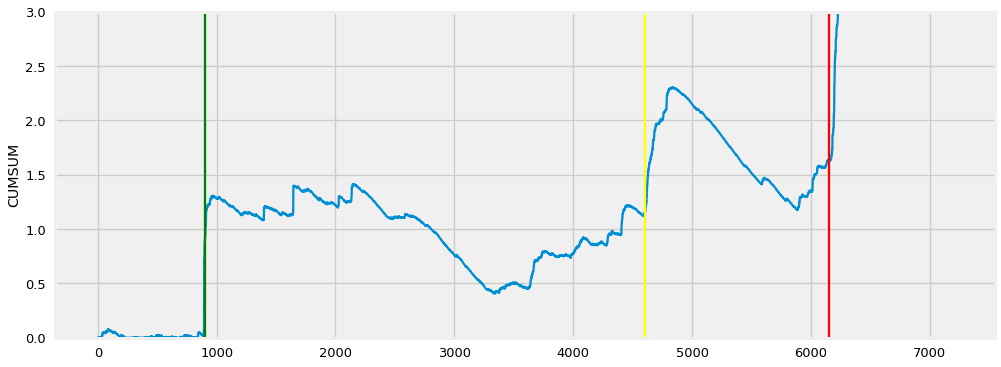

In [791]:
plt.figure(figsize=(15,6))
plt.plot(cum)
plt.axvline(900, -1, 1, color='green')
plt.axvline(4601, -1, 1, color='yellow')
plt.axvline(6150, -1, 1, color='red')
plt.ylabel("CUMSUM")
plt.ylim((0, 3))
plt.grid(True)
plt.show()

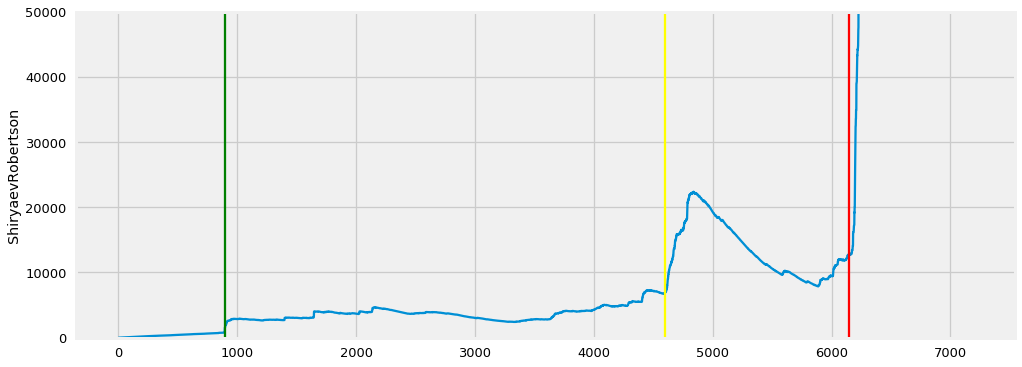

In [792]:
plt.figure(figsize=(15,6))
plt.plot(SR)
plt.axvline(900, -1, 1, color='green')
plt.axvline(4601, -1, 1, color='yellow')
plt.axvline(6150, -1, 1, color='red')
plt.ylabel("ShiryaevRobertson")
plt.ylim((0, 50000))
plt.grid(True)
plt.show()

Таким образом мы смогли обнаружить самый последний разлад с очень небольшой задержкой. Но хотелось бы в идеале обнаружить все, поэтому попробуем уменьшить границы.

Рассмотрим $h = 2$ для CUMSUM и $h = 20000$ для статистики Ширяева-Роберсона

In [793]:
f_inf = sps.norm(0, np.std(df_FTSE["ftse100"][:200])).pdf
f_0   = sps.norm(0, np.std(df_FTSE["ftse100"][:200]) + 2 * 1e-5).pdf

cum = CUMSUM(df_FTSE["ftse100"], f_inf, f_0)
SR = ShiryaevRobertson(df_FTSE["ftse100"], f_inf, f_0)

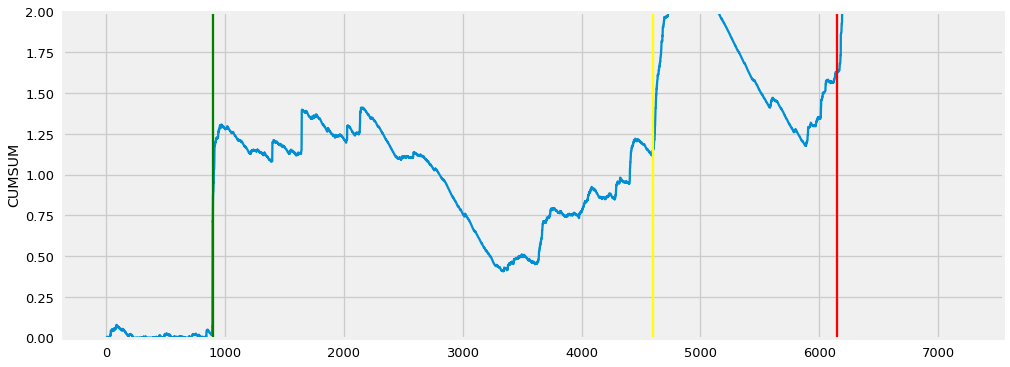

In [794]:
plt.figure(figsize=(15,6))
plt.plot(cum)
plt.axvline(900, -1, 1, color='green')
plt.axvline(4601, -1, 1, color='yellow')
plt.axvline(6150, -1, 1, color='red')
plt.ylabel("CUMSUM")
plt.ylim((0, 2))
plt.grid(True)
plt.show()

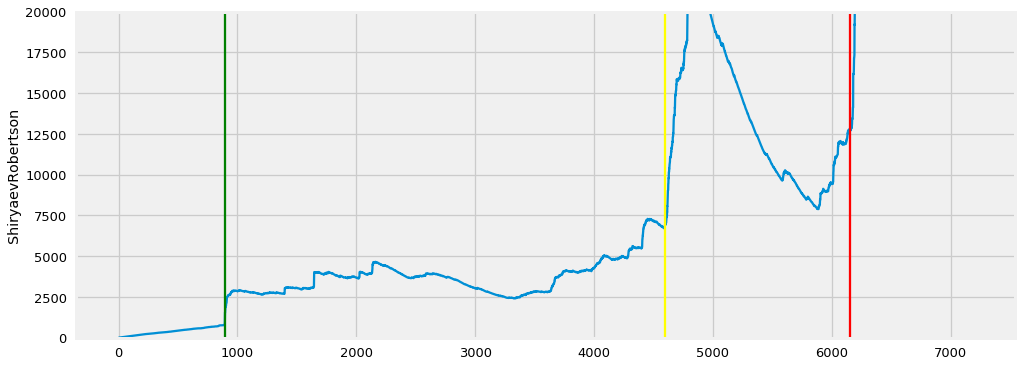

In [795]:
plt.figure(figsize=(15,6))
plt.plot(SR)
plt.axvline(900, -1, 1, color='green')
plt.axvline(4601, -1, 1, color='yellow')
plt.axvline(6150, -1, 1, color='red')
plt.ylabel("ShiryaevRobertson")
plt.ylim((0, 20000))
plt.grid(True)
plt.show()

Теперь мы смогли обнаружить второй разлад, но сможем мы обнаружить третий, если запустим заново.

In [796]:
f_inf = sps.norm(0, np.std(df_FTSE["ftse100"][5000:5000+200])).pdf
f_0   = sps.norm(0, np.std(df_FTSE["ftse100"][5000:5000+200]) + 2 * 1e-5).pdf

cum = CUMSUM(df_FTSE["ftse100"][5000:], f_inf, f_0)
SR = ShiryaevRobertson(df_FTSE["ftse100"][5000:], f_inf, f_0)

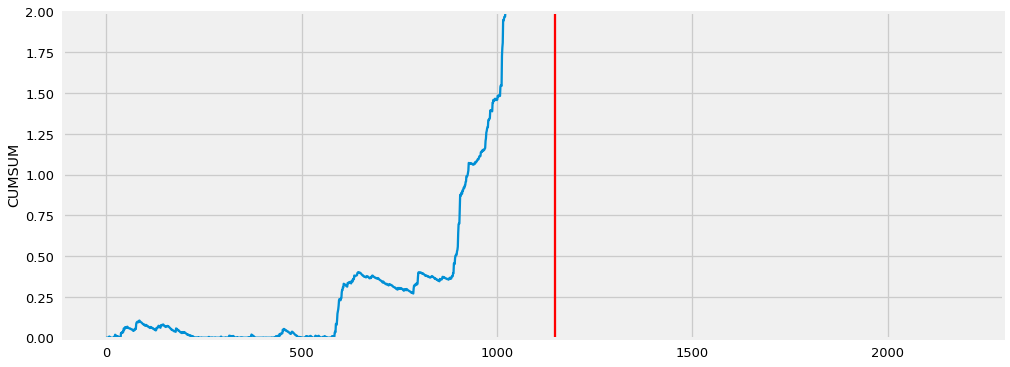

In [797]:
plt.figure(figsize=(15,6))
plt.plot(cum)
plt.axvline(6150 - 5000, -1, 1, color='red')
plt.ylabel("CUMSUM")
plt.ylim((0, 2))
plt.grid(True)
plt.show()

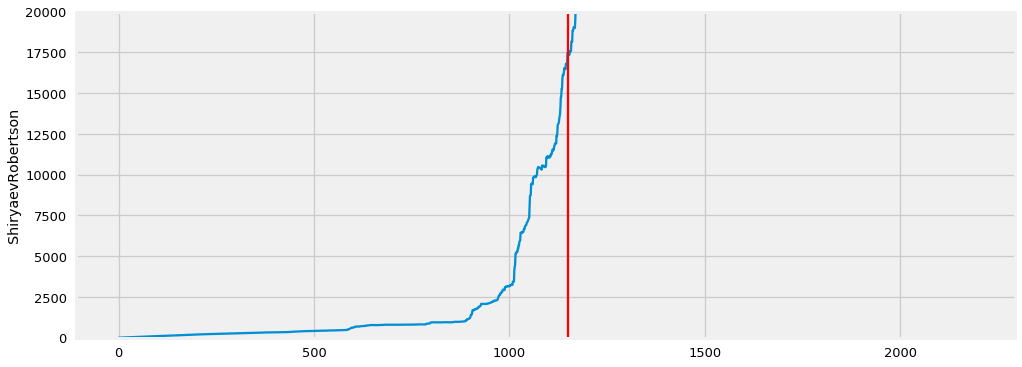

In [798]:
plt.figure(figsize=(15,6))
plt.plot(SR)
plt.axvline(6150 - 5000, -1, 1, color='red')
plt.ylabel("ShiryaevRobertson")
plt.ylim((0, 20000))
plt.grid(True)
plt.show()

Получилось. Немного раньше в случае CUMSUM, но все таки не плохо. Но теперь попробуем обнаружить все разлады.

Рассмотрим $h = 1$ для CUMSUM и $h = 2500$ для статистики Ширяева-Роберсона

In [799]:
f_inf = sps.norm(0, np.std(df_FTSE["ftse100"][:200])).pdf
f_0   = sps.norm(0, np.std(df_FTSE["ftse100"][:200]) + 2 * 1e-5).pdf

cum = CUMSUM(df_FTSE["ftse100"], f_inf, f_0)
SR = ShiryaevRobertson(df_FTSE["ftse100"], f_inf, f_0)

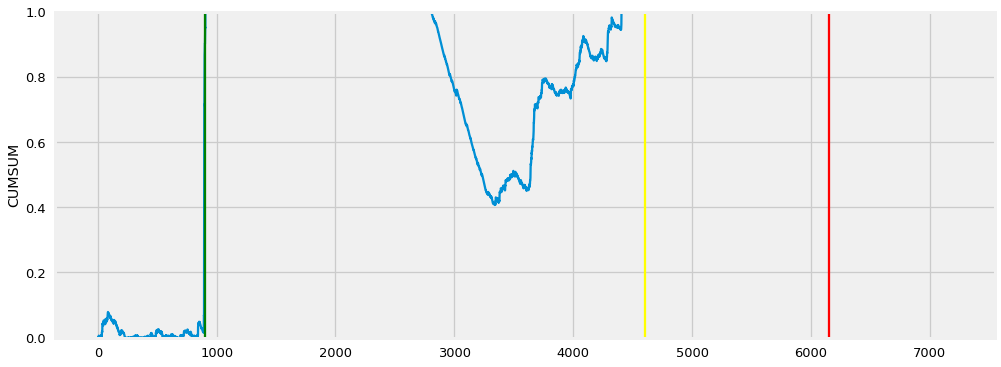

In [800]:
plt.figure(figsize=(15,6))
plt.plot(cum)
plt.axvline(900, -1, 1, color='green')
plt.axvline(4601, -1, 1, color='yellow')
plt.axvline(6150, -1, 1, color='red')
plt.ylabel("CUMSUM")
plt.ylim((0, 1))
plt.grid(True)
plt.show()

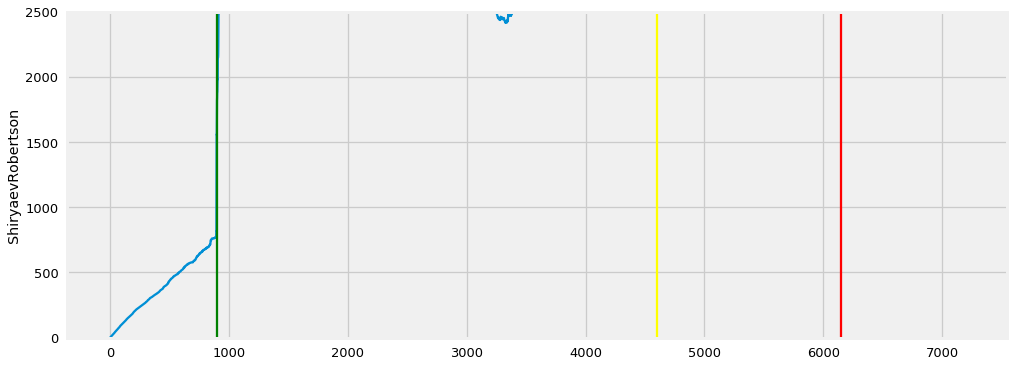

In [801]:
plt.figure(figsize=(15,6))
plt.plot(SR)
plt.axvline(900, -1, 1, color='green')
plt.axvline(4601, -1, 1, color='yellow')
plt.axvline(6150, -1, 1, color='red')
plt.ylabel("ShiryaevRobertson")
plt.ylim((0, 2500))
plt.grid(True)
plt.show()

Обнаружить первую разладку с такими параметрами не составляет труда

In [802]:
f_inf = sps.norm(0, np.std(df_FTSE["ftse100"][1000:1000+200])).pdf
f_0   = sps.norm(0, np.std(df_FTSE["ftse100"][1000:1000+200]) + 2 * 1e-5).pdf

cum = CUMSUM(df_FTSE["ftse100"][1000:], f_inf, f_0)
SR = ShiryaevRobertson(df_FTSE["ftse100"][1000:], f_inf, f_0)

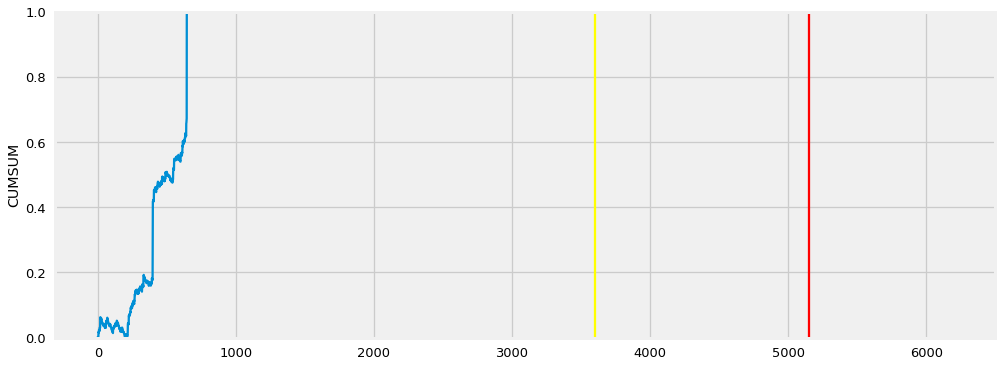

In [803]:
plt.figure(figsize=(15,6))
plt.plot(cum)
plt.axvline(4601 - 1000, -1, 1, color='yellow')
plt.axvline(6150 - 1000, -1, 1, color='red')
plt.ylabel("CUMSUM")
plt.ylim((0, 1))
plt.grid(True)
plt.show()

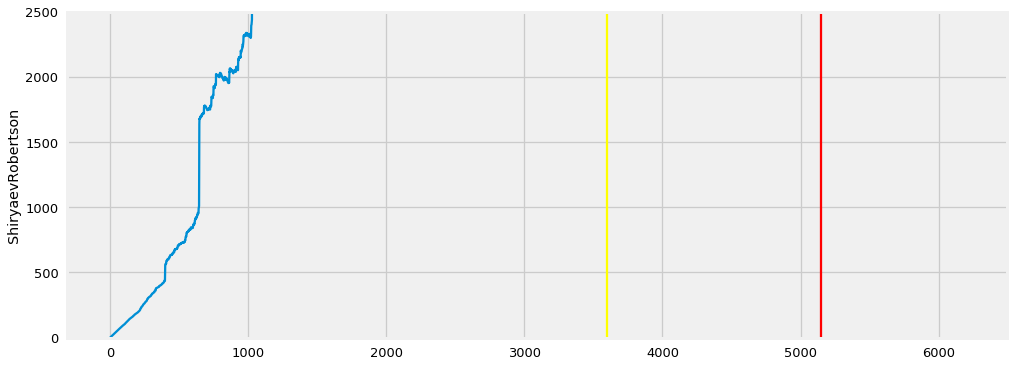

In [804]:
plt.figure(figsize=(15,6))
plt.plot(SR)
plt.axvline(4601 - 1000, -1, 1, color='yellow')
plt.axvline(6150 - 1000, -1, 1, color='red')
plt.ylabel("ShiryaevRobertson")
plt.ylim((0, 2500))
plt.grid(True)
plt.show()

Обе статистики обнаружили какой-то разлад в районе $1700-2000$

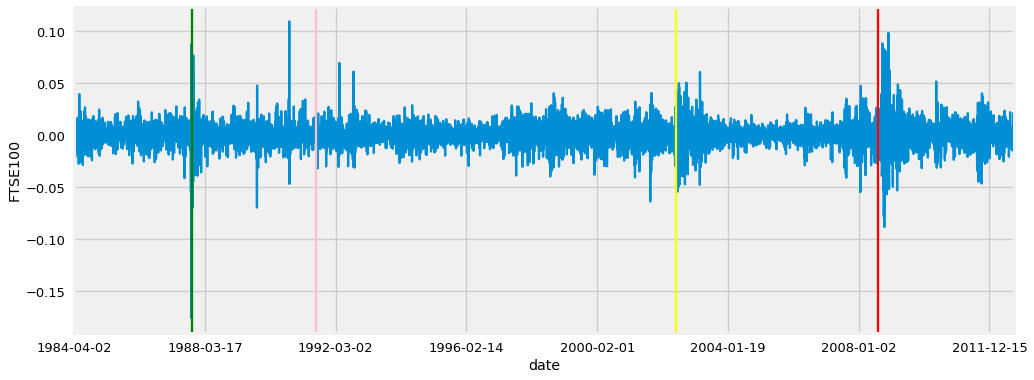

In [811]:
df_FTSE["ftse100"].plot(figsize=(15,6))
plt.axvline(900, -1, 1, color='green')
plt.axvline(1850, -1, 1, color='pink')
plt.axvline(4600, -1, 1, color='yellow')
plt.axvline(6150, -1, 1, color='red')
plt.ylabel("FTSE100")
plt.grid(True)
plt.show()

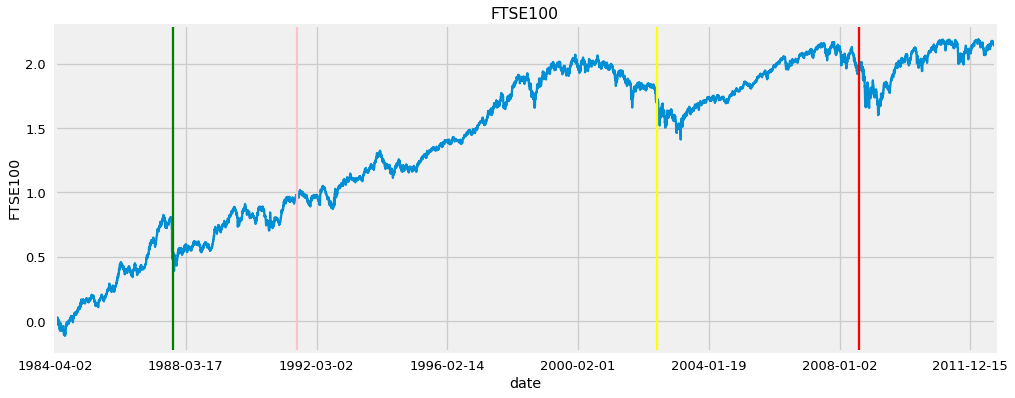

In [812]:
df_FTSE["cumsum"].plot(figsize=(15,6))
plt.axvline(900, -1, 1, color='green')
plt.axvline(1850, -1, 1, color='pink')
plt.axvline(4600, -1, 1, color='yellow')
plt.axvline(6150, -1, 1, color='red')
plt.ylabel("FTSE100")
plt.grid(True)
plt.title("FTSE100")
plt.show()

По графикам на разлад не похоже, получается, что мы наблюдаем ложное срабатываение. Продолжим наши наблюдения

In [813]:
f_inf = sps.norm(0, np.std(df_FTSE["ftse100"][2000:2000+200])).pdf
f_0   = sps.norm(0, np.std(df_FTSE["ftse100"][2000:2000+200]) + 2 * 1e-5).pdf

cum = CUMSUM(df_FTSE["ftse100"][2000:], f_inf, f_0)
SR = ShiryaevRobertson(df_FTSE["ftse100"][2000:], f_inf, f_0)

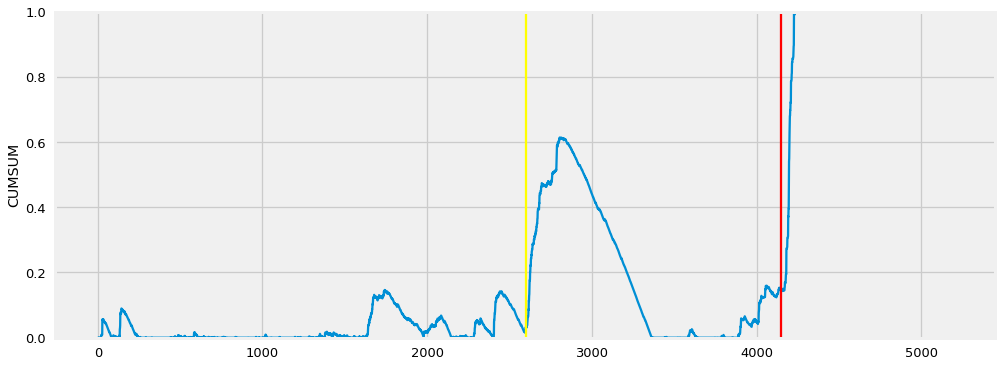

In [814]:
plt.figure(figsize=(15,6))
plt.plot(cum)
plt.axvline(4601 - 2000, -1, 1, color='yellow')
plt.axvline(6150 - 2000, -1, 1, color='red')
plt.ylabel("CUMSUM")
plt.ylim((0, 1))
plt.grid(True)
plt.show()

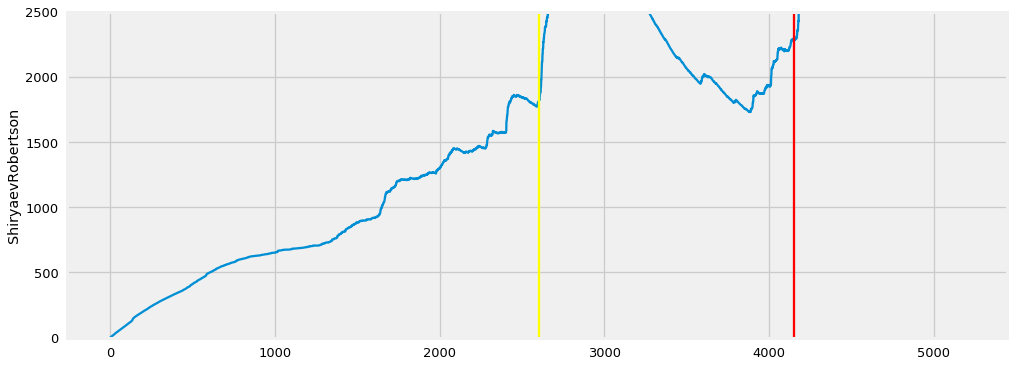

In [815]:
plt.figure(figsize=(15,6))
plt.plot(SR)
plt.axvline(4601 - 2000, -1, 1, color='yellow')
plt.axvline(6150 - 2000, -1, 1, color='red')
plt.ylabel("ShiryaevRobertson")
plt.ylim((0, 2500))
plt.grid(True)
plt.show()

Первая статистика пропустила наш жёлтый разлад, что является очень плохим показателем. А вторая по-прежнему справляется поэтому последнее действие проделаем только для нее.

In [816]:
f_inf = sps.norm(0, np.std(df_FTSE["ftse100"][5000:5000+200])).pdf
f_0   = sps.norm(0, np.std(df_FTSE["ftse100"][5000:5000+200]) + 2 * 1e-5).pdf

# cum = CUMSUM(df_FTSE["ftse100"][2000:], f_inf, f_0)
SR = ShiryaevRobertson(df_FTSE["ftse100"][5000:], f_inf, f_0)

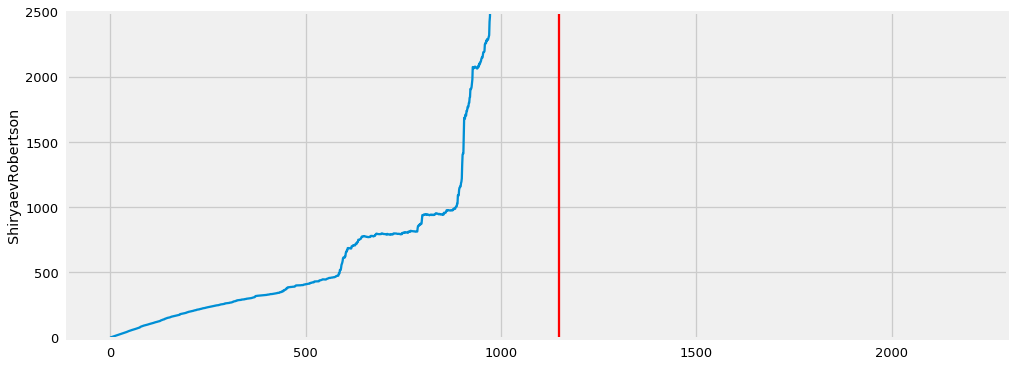

In [818]:
plt.figure(figsize=(15,6))
plt.plot(SR)
plt.axvline(6150 - 5000, -1, 1, color='red')
plt.ylabel("ShiryaevRobertson")
plt.ylim((0, 2500))
plt.grid(True)
plt.show()

И последний разлад обнаружен, хоть и немного раньше.

<span>4.</span> Обнаруживают ли статистики все имеющиеся разладки во временном ряде? Какая при этом задержка при подаче сигнала? Сколько ложных тревог?

Итого лучше всего себя проявила статистика Ширяева-Роберста в последнем случае, она смогла обнаружить все разлады, но также выдала одну ложную тревогу.

Что же касается статистики CUMSUM, то лучший результат получился во втором случае, а именно два обнаружения и без ложных тревог

## Анализ интернет трафика

Считаем данные

In [819]:
df_int = pd.read_csv('internet-traffic.csv', index_col="Time", sep=";")
df_int.head()

,Internet traffic data (in bits) from an ISP
Time,
2004-11-19 09:30:00,64554.479
2004-11-19 10:30:00,71138.749
2004-11-19 11:30:00,77253.266
2004-11-19 12:30:00,77340.780
2004-11-19 13:30:00,79860.759


Построим график

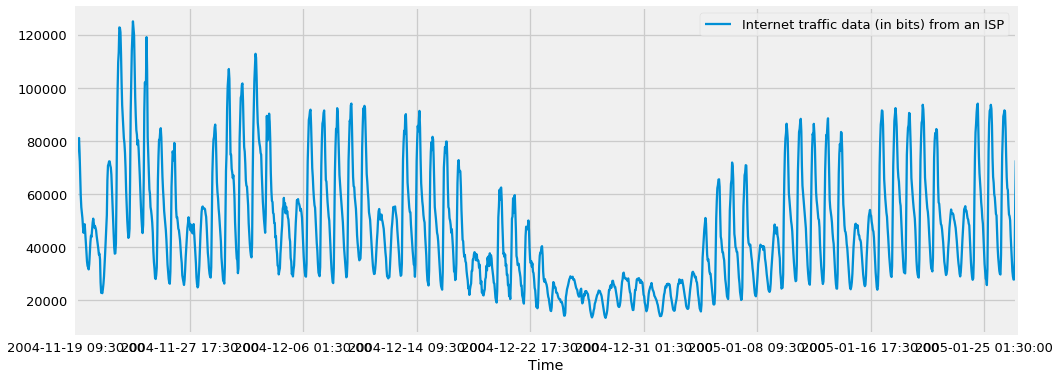

In [820]:
df_int.plot(figsize=(15,6))
plt.grid(True)
plt.show()

Предположительный разлад обозначим красной полоской

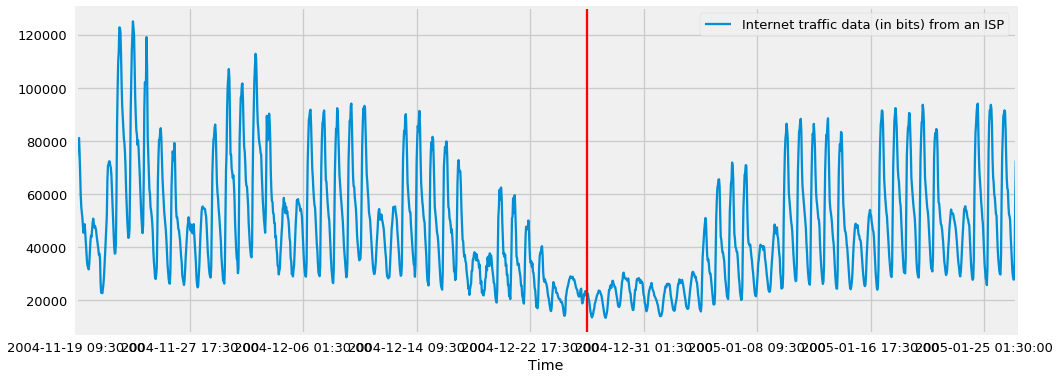

In [828]:
df_int.plot(figsize=(15,6))
plt.axvline(900, -1, 1, color='red')
plt.grid(True)
plt.show()

Видим множество сезонностей, а они будут мешать, поэтому постараемся их по-возможности убрать

In [832]:
sample = df_int["Internet traffic data (in bits) from an ISP"].values

In [833]:
month_diff = sample[24*7*4:] - sample[:-24*7*4]
week_diff = month_diff[24*7:] - month_diff[:-24*7]
day_diff = week_diff[24:] - week_diff[:-24]
hour_diff = day_diff[1:] - day_diff[:-1]

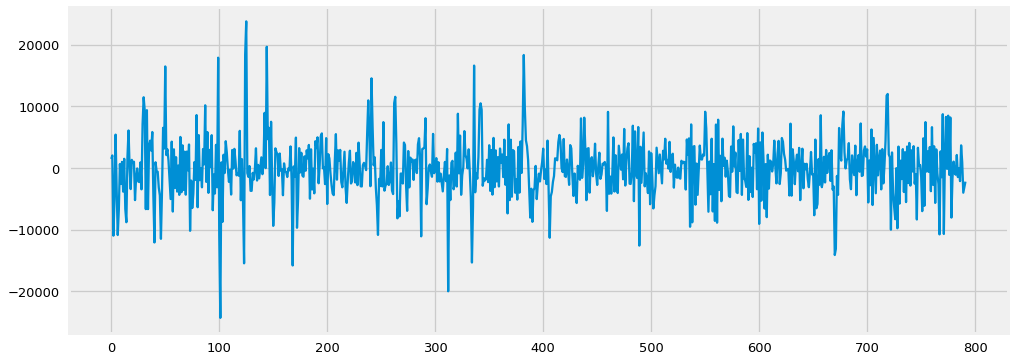

In [834]:
plt.figure(figsize=(15,6))
plt.plot(hour_diff)

plt.show()

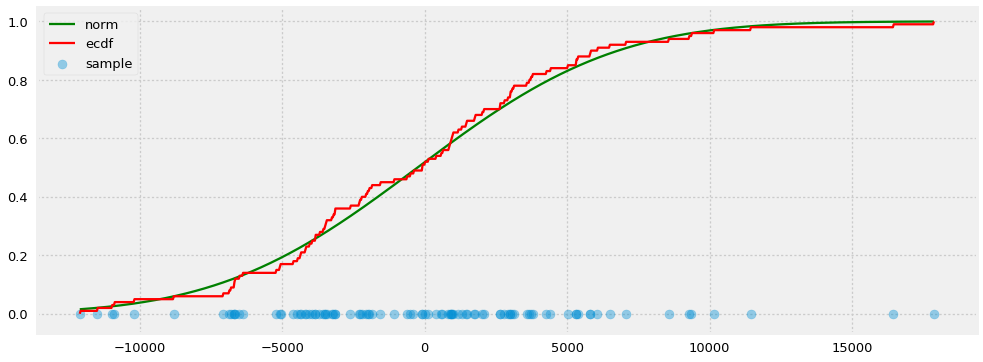

In [846]:
int_ecdf = ECDF(hour_diff[:100])

grid = np.linspace(np.min(hour_diff[:100]) - 10, np.max(hour_diff[:100]) + 10, 1000)

plt.figure(figsize=(15, 6))
plt.scatter(hour_diff[:100], 
            np.zeros(100), alpha=0.4, label='sample')
plt.plot(grid, sps.norm(np.mean(hour_diff[:100]), np.std(hour_diff[:100])).cdf(grid), 
         color='green', label='norm')
plt.plot(grid, int_ecdf(grid), color='red', label='ecdf')
plt.legend()
plt.grid(ls=':')
plt.show()

In [880]:
f_inf = sps.norm(0, np.std(hour_diff[:100])).pdf
f_0 = sps.norm(0, np.std(hour_diff[:100]) + 1000).pdf

cum = CUMSUM(hour_diff, f_inf, f_0)
SR = ShiryaevRobertson(hour_diff, f_inf, f_0)

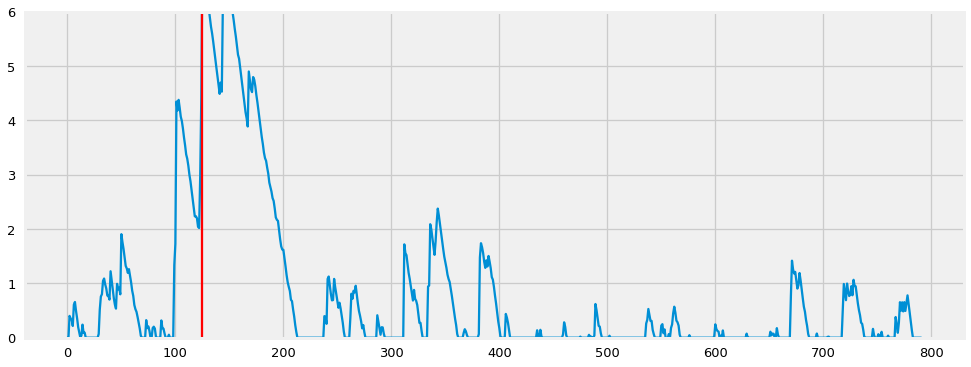

In [881]:
plt.figure(figsize=(15,6))
plt.plot(cum)
plt.axvline(125, -1, 1, color='red')
plt.ylim((0, 6))
plt.show()

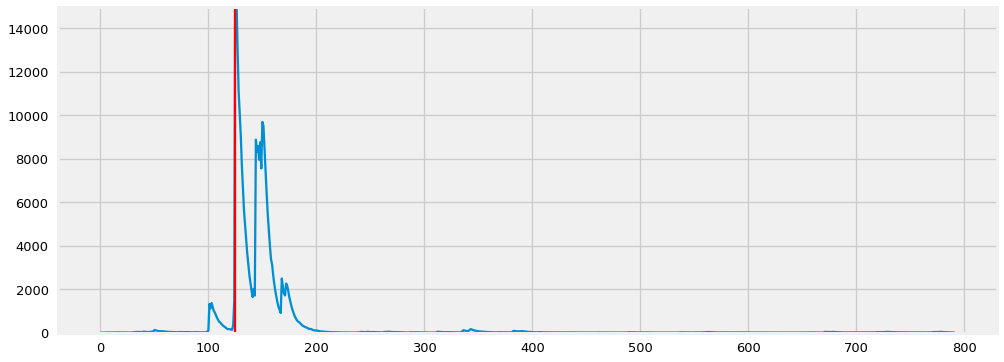

In [882]:
plt.figure(figsize=(15,6))
plt.plot(SR)
plt.axvline(125, -1, 1, color='red')
plt.ylim((0, 15000))
plt.show()

Нашли разлад в районе $125$, посмотрим какое это значение для исходного

In [883]:
print(125 + 1 + 24 + 24 * 7 + 24 * 7 * 4)

990


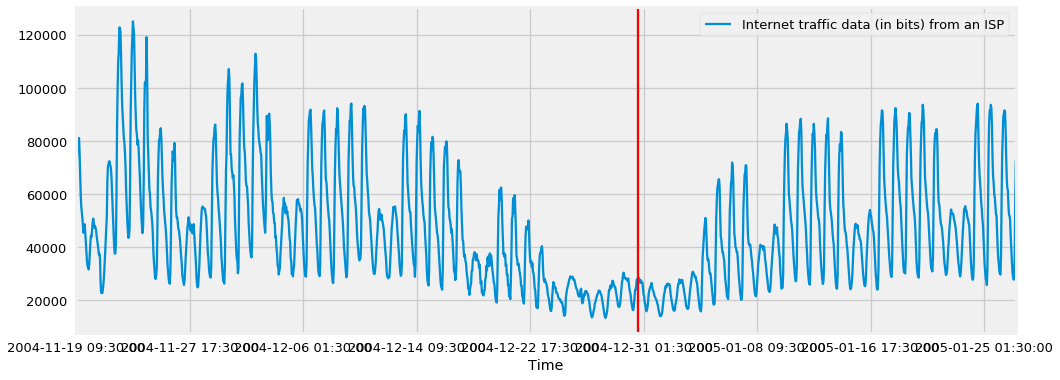

In [884]:
df_int.plot(figsize=(15,6))
plt.axvline(990, -1, 1, color='red')
plt.grid(True)
plt.show()

Получили как раз нужный нам разлад с небольшой задержкой